In [62]:
# initializing
library(tidyverse)
library(scales)
library(tidymodels)
library(dplyr)

# reading/wrangling the data
players_data <- read_csv("data/players.csv") |>
    mutate(subscribe = as_factor(subscribe)) |>
    select(subscribe, played_hours, Age)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 7

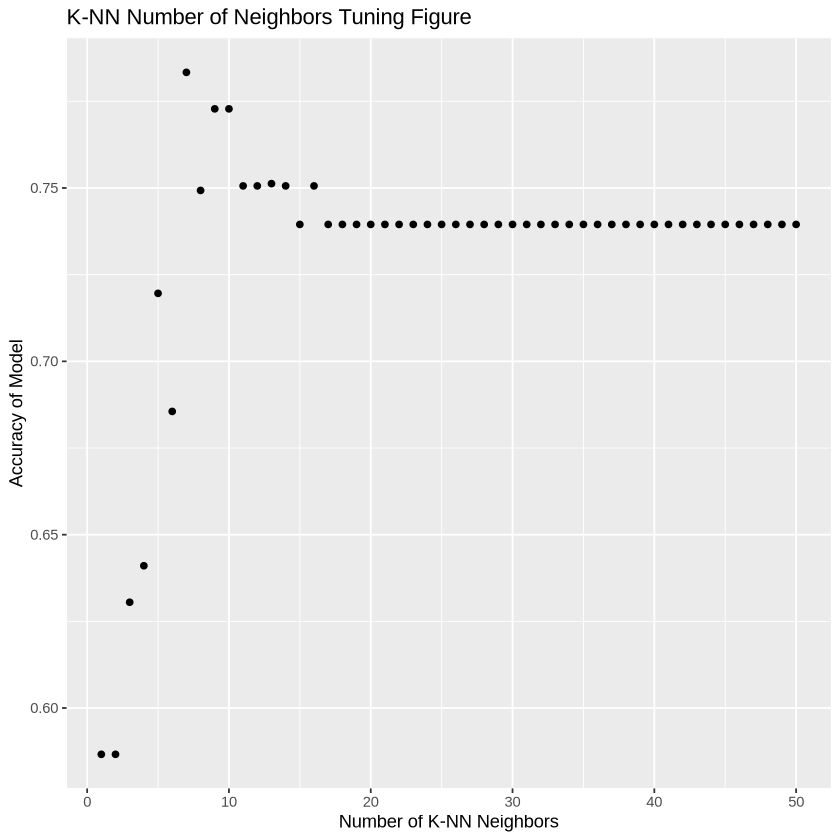

In [63]:
# finding optimal neighbors
set.seed(1)

players_split <- initial_split(players_data, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

k_neighbors_plot <- ggplot(players_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(y = "Accuracy of Model", x = "Number of K-NN Neighbors") +
    ggtitle("K-NN Number of Neighbors Tuning Figure")
k_neighbors_plot

neighbors_best <- players_fit |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
neighbors_best

In [65]:
# using the optimal neighbors model

players_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit_optimal <- workflow() |>
    add_model(players_spec_optimal) |>
    add_recipe(players_recipe) |>
    fit(data = test) |>
    predict(test) |>
    bind_cols(test)

# gathering metrics

players_fit_accuracy <- players_fit_optimal |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_fit_precision <- players_fit_optimal |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

players_fit_recall <- players_fit_optimal |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

print(players_fit_accuracy)
print(players_fit_precision)
print(players_fit_recall)